In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/countries-of-the-world/countries of the world.csv
/kaggle/input/cleaned/cleaned_countries.csv


Read the cleaned version, which was cleaned in one of the previous Python analysis from the same kaggle dataset

In [2]:
countries = pd.read_csv("/kaggle/input/cleaned/cleaned_countries.csv", index_col = 0)

In [3]:
## Check

countries.head()

,Country,Region,Population,Area,Pop._Density,Coastline,Net_migration,Infant_mortality,GDP,Literacy,...,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service,landlocked,cluster_labels
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,480,0,2306.0,16307.0,700.0,360.0,...,22.0,8765.0,1.0,466.0,2034.0,38.0,24.000000,38.000,1,2
1,Albania,EASTERN EUROPE,3581655,28748,1246,126,-493.0,2152.0,4500.0,865.0,...,442.0,7449.0,3.0,1511.0,522.0,232.0,188.000000,579.000,0,1
2,Algeria,NORTHERN AFRICA,32930091,2381740,138,4,-39.0,31.0,6000.0,700.0,...,25.0,9653.0,1.0,1714.0,461.0,101.0,6.000000,298.000,0,1
3,American Samoa,OCEANIA,57794,199,2904,5829,-2071.0,927.0,8000.0,970.0,...,15.0,75.0,2.0,2246.0,327.0,115.5,169.687500,473.375,0,1
4,Andorra,WESTERN EUROPE,71201,468,1521,0,66.0,405.0,19000.0,1000.0,...,0.0,9778.0,3.0,871.0,625.0,18.2,159.458333,492.625,1,3


## Check for missing entries

In [4]:
## Check for missing 

## Check for missing along each column, i.e. axis = 0
countries.isna().sum(axis = 0)

Country             0
Region              0
Population          0
Area                0
Pop._Density        0
Coastline           0
Net_migration       0
Infant_mortality    0
GDP                 0
Literacy            0
Phones              0
Arable              0
Crops               0
Other               0
Climate             0
Birthrate           0
Deathrate           0
Agriculture         0
Industry            0
Service             0
landlocked          0
cluster_labels      0
dtype: int64

# Modelling GDP via country predictors

Modelling GDP, as we have done in the previous analysis, is essentially a regression process since it involves predicting an outcome that is continuous and numeric. 

We can imitate a regular multiple linear model via a very basic, two layered neural network, that essentially gives a parameter to each predictor (the weight, i.e. the coefficients) and then one parameter to the bias (i.e. the constant)

## Data preparation: train test split + standardisation

In [5]:
## First, we drop the country column, that is unique to each level and does not help us make any predictions as it cannot generalise 
X = countries.drop(columns = ['Country', 'GDP'])

## Check 
print(X.head())

                                Region  Population     Area  Pop._Density  \
0        ASIA (EX. NEAR EAST)             31056997   647500           480   
1  EASTERN EUROPE                          3581655    28748          1246   
2  NORTHERN AFRICA                        32930091  2381740           138   
3  OCEANIA                                   57794      199          2904   
4  WESTERN EUROPE                            71201      468          1521   

   Coastline  Net_migration  Infant_mortality  Literacy  Phones  Arable  \
0          0         2306.0           16307.0     360.0    32.0  1213.0   
1        126         -493.0            2152.0     865.0   712.0  2109.0   
2          4          -39.0              31.0     700.0   781.0   322.0   
3       5829        -2071.0             927.0     970.0  2595.0    10.0   
4          0           66.0             405.0    1000.0  4972.0   222.0   

   Crops   Other  Climate  Birthrate  Deathrate  Agriculture    Industry  \
0   22.0  

In [6]:
## We also remove cluster labels 
X = X.drop(columns = ['cluster_labels'])

In [7]:
## Check data types
X.dtypes

Region               object
Population            int64
Area                  int64
Pop._Density          int64
Coastline             int64
Net_migration       float64
Infant_mortality    float64
Literacy            float64
Phones              float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
landlocked            int64
dtype: object

Apart from Region, the rest are numeric and require standardising. Since Region is categorical, we may also have to handle it separately and apply some sort of encoding. 

In [8]:
print(countries.Region.value_counts())
print('=============== \n')
print("Number of classes of Region ", countries.Region.nunique())

Region
SUB-SAHARAN AFRICA                     51
LATIN AMER. & CARIB                    45
ASIA (EX. NEAR EAST)                   28
WESTERN EUROPE                         28
OCEANIA                                21
NEAR EAST                              16
EASTERN EUROPE                         12
C.W. OF IND. STATES                    12
NORTHERN AFRICA                         6
NORTHERN AMERICA                        5
BALTICS                                 3
Name: count, dtype: int64

Number of classes of Region  11


As seen, we have 11 classes of different regions. 

### Encoding the categorical variable

Unlike R that recgonises strings type as factorial and will automatically handle categorical data as dummy variables such as in the built in linear regression model methods, we often have to explicitly deal with categorical variables in Python. 

The common method is one hot encoding, which. 

In [9]:
print('Original number of columns ', X.shape[1])
X_with_ohe = pd.get_dummies(X, columns = ['Region'])
print('After introducing one hot encoding, ', X_with_ohe.shape[1])

Original number of columns  19
After introducing one hot encoding,  29


We introduced 11 dummies and removed the original 1 column for region, hence net increase in 10 columns 

In [10]:
## Check the new dummy columns 
region_dummies = [col for col in X_with_ohe.columns if col.startswith('Region') ]
print(region_dummies)

## Need to clean up the trailing white space 
## Clear for all column names 
X_with_ohe.columns = [col.strip() for col in X_with_ohe.columns]



['Region_ASIA (EX. NEAR EAST)         ', 'Region_BALTICS                            ', 'Region_C.W. OF IND. STATES ', 'Region_EASTERN EUROPE                     ', 'Region_LATIN AMER. & CARIB    ', 'Region_NEAR EAST                          ', 'Region_NORTHERN AFRICA                    ', 'Region_NORTHERN AMERICA                   ', 'Region_OCEANIA                            ', 'Region_SUB-SAHARAN AFRICA                 ', 'Region_WESTERN EUROPE                     ']


In [11]:
## Check again 
region_dummies = [col for col in X_with_ohe.columns if col.startswith('Region') ]
print(region_dummies)

['Region_ASIA (EX. NEAR EAST)', 'Region_BALTICS', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_NEAR EAST', 'Region_NORTHERN AFRICA', 'Region_NORTHERN AMERICA', 'Region_OCEANIA', 'Region_SUB-SAHARAN AFRICA', 'Region_WESTERN EUROPE']


In [12]:
print('The dummies are the following : ', region_dummies, ' \n \n count : ', len(region_dummies))
print('\n ================')
print('The regions are : ', [region.strip() for region in countries.Region.unique().tolist()], ' \n \n count : ', countries.Region.nunique())

The dummies are the following :  ['Region_ASIA (EX. NEAR EAST)', 'Region_BALTICS', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_NEAR EAST', 'Region_NORTHERN AFRICA', 'Region_NORTHERN AMERICA', 'Region_OCEANIA', 'Region_SUB-SAHARAN AFRICA', 'Region_WESTERN EUROPE']  
 
 count :  11

The regions are :  ['ASIA (EX. NEAR EAST)', 'EASTERN EUROPE', 'NORTHERN AFRICA', 'OCEANIA', 'WESTERN EUROPE', 'SUB-SAHARAN AFRICA', 'LATIN AMER. & CARIB', 'C.W. OF IND. STATES', 'NEAR EAST', 'NORTHERN AMERICA', 'BALTICS']  
 
 count :  11


### Standardising the data

In [13]:
## Names of columns which are numeric 
numeric_cols = X.select_dtypes(exclude = 'object').columns ## Choose only the numeric types 
print(numeric_cols)

## Numeric subset 
X_encoded_numeric_subset = X_with_ohe[numeric_cols]
print(X_encoded_numeric_subset.head())

Index(['Population', 'Area', 'Pop._Density', 'Coastline', 'Net_migration',
       'Infant_mortality', 'Literacy', 'Phones', 'Arable', 'Crops', 'Other',
       'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry',
       'Service', 'landlocked'],
      dtype='object')
   Population     Area  Pop._Density  Coastline  Net_migration  \
0    31056997   647500           480          0         2306.0   
1     3581655    28748          1246        126         -493.0   
2    32930091  2381740           138          4          -39.0   
3       57794      199          2904       5829        -2071.0   
4       71201      468          1521          0           66.0   

   Infant_mortality  Literacy  Phones  Arable  Crops   Other  Climate  \
0           16307.0     360.0    32.0  1213.0   22.0  8765.0      1.0   
1            2152.0     865.0   712.0  2109.0  442.0  7449.0      3.0   
2              31.0     700.0   781.0   322.0   25.0  9653.0      1.0   
3             927.0     970.0  25

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
# Init the scaler then scale the numeric X data
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_encoded_numeric_subset)



In [16]:
## Check that data has been scaled 
print(X_numeric_scaled.shape)
print(X_numeric_scaled.mean(axis = 0))
print(X_numeric_scaled.std(axis = 0))

(227, 18)
[-7.82536053e-18  3.91268026e-17 -1.95634013e-17  2.34760816e-17
 -3.91268026e-18 -2.34760816e-17  2.66062258e-16  1.01729687e-16
  1.93677673e-16  3.91268026e-18 -7.82536053e-17  1.56507211e-17
  0.00000000e+00 -1.56507211e-16 -7.82536053e-18 -1.13467728e-16
 -1.09555047e-16 -7.82536053e-18]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Now, rejoin the OHE with the standardised numeric data

In [17]:
X_with_ohe[numeric_cols] = X_numeric_scaled
print(X_with_ohe.head())

   Population      Area  Pop._Density  Coastline  Net_migration  \
0    0.019695  0.027583     -0.199844  -0.293443       4.852624   
1   -0.213877 -0.318797     -0.153603  -0.275974      -1.064261   
2    0.035618  0.998421     -0.220490  -0.292889      -0.104537   
3   -0.243834 -0.334779     -0.053514   0.514709      -4.400039   
4   -0.243720 -0.334629     -0.137002  -0.293443       0.117425   

   Infant_mortality  Literacy    Phones    Arable     Crops  ...  \
0          3.789050 -2.466929 -1.027952  0.039439 -0.481530  ...   
1         -0.287313  0.162033 -0.726675  0.747141  0.036493  ...   
2         -0.898119 -0.696935 -0.696105 -0.664314 -0.477829  ...   
3         -0.640089  0.708649  0.107595 -0.910746 -0.490163  ...   
4         -0.790415  0.864825  1.160734 -0.743298 -0.508664  ...   

   Region_BALTICS  Region_C.W. OF IND. STATES  Region_EASTERN EUROPE  \
0           False                       False                  False   
1           False                       Fals

In [18]:
y = countries.GDP

### Train test split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_with_ohe, y, test_size=0.2, random_state=42)


In [21]:
## Check 
print(X_train.shape) ## 181 training samples 
print(X_test.shape) ## 46 test samples 

(181, 29)
(46, 29)


# Model building !

## Model 1: Building a simple linear model with one input and one output layer of neural networks 

To mimic a linear model, where the output is modelled by a linear combination of each predictor without any non-linear activation function, we add one layer only with a single output.

In [22]:
from tensorflow.keras.models import Sequential ## for the model
from tensorflow.keras.layers import Dense ## for each fully connected layer of the model

In [23]:
# Create a sequential model
nn_model_linear = Sequential()

# Add a dense layer 
nn_model_linear.add(Dense(units = 1, input_shape=(X_train.shape[1],),  ## the input shape should be the number of predictors in our training sample
                          activation=None))

## Get model summary
nn_model_linear.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


There are 30 parameters - one weight for each of our 29 predictors, followed by a bias (constant)

### Visualise the neural network?

In [24]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 13.1 MB/s eta 0:00:00


In [25]:
import visualkeras

In [26]:
visualkeras.layered_view(nn_model_linear)

The model is obviously very simple, since it contains no hidden layers

#### Compile and train

In [27]:
## Important before fitting: convert our data into the correct tensor type 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [28]:
## Compile, use MSE since regression
nn_model_linear.compile(optimizer = 'adam', 
                       loss = 'mean_squared_error',
                       metrics = ['mae', 'mse'])

## Train model 
# Train your model for 20 epochs
nn_model_linear.fit(X_train, y_train, epochs = 100)

# Evaluate your model accuracy on the test set
accuracy = nn_model_linear.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

Epoch 1/100
6/6 [==============================] - 1s 4ms/step - loss: 201879232.0000 - mae: 9878.7842 - mse: 201879232.0000
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 201878464.0000 - mae: 9878.7705 - mse: 201878464.0000
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 201877760.0000 - mae: 9878.7578 - mse: 201877760.0000
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 201877104.0000 - mae: 9878.7461 - mse: 201877104.0000
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 201876368.0000 - mae: 9878.7334 - mse: 201876368.0000
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 201875680.0000 - mae: 9878.7227 - mse: 201875680.0000
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 201875008.0000 - mae: 9878.7109 - mse: 201875008.0000
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 201874256.0000 - mae: 9878.6963 - mse: 201874256.0000


### Test set results

In [29]:
## Evaluate on test set
nn_model_linear.evaluate(X_test, y_test)[1]

2/2 [==============================] - 0s 6ms/step - loss: 161509024.0000 - mae: 8853.9102 - mse: 161509024.0000


8853.91015625

### Model results

In [30]:
weights,bias = nn_model_linear.layers[0].get_weights()
print(weights)
print(len(weights))

print(bias)

[[ 0.15696888]
 [ 0.46151847]
 [ 0.59032834]
 [-0.03710547]
 [ 0.7799941 ]
 [-0.3936043 ]
 [ 0.33862138]
 [ 0.6792382 ]
 [-0.275383  ]
 [-0.11318868]
 [-0.19445899]
 [-0.82836026]
 [-0.2602799 ]
 [-0.1001996 ]
 [-1.0138092 ]
 [-0.01302857]
 [ 0.3285463 ]
 [-0.12596822]
 [ 0.49917665]
 [ 0.14876193]
 [ 0.45378038]
 [ 0.18726584]
 [ 0.66115326]
 [ 0.57733876]
 [ 0.48541734]
 [ 0.5440641 ]
 [ 0.14826334]
 [ 0.6147276 ]
 [ 0.24356142]]
29
[0.59113705]


In [31]:
## ============= Combine all the estimated parameters together (i.e. combine weights and bias)
print(weights.shape)
print(bias.shape)

## In order to concatenate them, we need to reshape one to match the other -- we will reshape the bias to match a 2D shape via reshape(-1,1)
print(bias.reshape(-1,1).shape)

bias_weights = np.concatenate([bias.reshape(-1,1), weights]) ## to concatenate them, they need to both be the same shape -- weights is currently 
print(bias_weights.shape)

## ============== Add the 'bias' string element into X_train.columns
all_predictor_names = ['Bias'] + X_train.columns.tolist() 

(29, 1)
(1,)
(1, 1)
(30, 1)


In [32]:
coefficients_df = pd.DataFrame({'Predictors' : all_predictor_names, 'Estimated_values': bias_weights.ravel()}) ## ravel to flatten any multidimen array to 1D
print(coefficients_df)

                     Predictors  Estimated_values
0                          Bias          0.591137
1                    Population          0.156969
2                          Area          0.461518
3                  Pop._Density          0.590328
4                     Coastline         -0.037105
5                 Net_migration          0.779994
6              Infant_mortality         -0.393604
7                      Literacy          0.338621
8                        Phones          0.679238
9                        Arable         -0.275383
10                        Crops         -0.113189
11                        Other         -0.194459
12                      Climate         -0.828360
13                    Birthrate         -0.260280
14                    Deathrate         -0.100200
15                  Agriculture         -1.013809
16                     Industry         -0.013029
17                      Service          0.328546
18                   landlocked         -0.125968


# Compare to a traditional linear regression model via SM 

In [33]:
import statsmodels.api as sm

## Adding a constant to predictor set
X_train_with_const = sm.add_constant(X_train)

## Fit the OLS model
ols_model = sm.OLS(y_train, X_train_with_const).fit()

## Check coefficients 
print(ols_model.summary())

## Save parameters 
ols_params = (ols_model.params.values)

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     21.12
Date:                Tue, 19 Sep 2023   Prob (F-statistic):           3.04e-39
Time:                        23:44:48   Log-Likelihood:                -1784.0
No. Observations:                 181   AIC:                             3626.
Df Residuals:                     152   BIC:                             3719.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [34]:
## Check OLS params from SM
print(ols_params)
print(len(ols_params))

## Append into results_df
coefficients_df['OLS_estimated_values'] = ols_params

[ 8623.90219851  -398.16661896   334.0508501   -238.62302199
  -159.60419394  1415.69474621  -679.53505956  1280.48812655
  5588.01153824   186.51602828  -381.93082145  1086.00670177
   -43.23862975   -69.52870107   -60.12775775  -939.1407671
   620.82519605   415.60880015   654.36413803  1420.8704619
 -2182.11341512 -4177.50638418 -2047.52580907 -1191.19681783
   834.58844128  1693.493774    4337.68652757  2363.74224251
  1268.70701169  6303.15616577]
30


In [35]:
## Print!
coefficients_df = coefficients_df.rename(columns = {'Estimated_values': 'NN_estimated_values'})
print(coefficients_df)

                     Predictors  NN_estimated_values  OLS_estimated_values
0                          Bias             0.591137           8623.902199
1                    Population             0.156969           -398.166619
2                          Area             0.461518            334.050850
3                  Pop._Density             0.590328           -238.623022
4                     Coastline            -0.037105           -159.604194
5                 Net_migration             0.779994           1415.694746
6              Infant_mortality            -0.393604           -679.535060
7                      Literacy             0.338621           1280.488127
8                        Phones             0.679238           5588.011538
9                        Arable            -0.275383            186.516028
10                        Crops            -0.113189           -381.930821
11                        Other            -0.194459           1086.006702
12                      C

As we can see, the results are very different for the same coefficients

In [36]:
## Other results
ols_pred = ols_model.predict(sm.add_constant(X_test))
print('OLS MAE = ', round(sm.tools.eval_measures.meanabs(ols_pred,y_test),2))
print('OLS MSE = ', round(sm.tools.eval_measures.mse(ols_pred,y_test),2)/1e6, 'x 10^6')
## Neural network
print('NN MAE = ', round(nn_model_linear.evaluate(X_test, y_test)[1],2))
print('NN MSE = ', round(nn_model_linear.evaluate(X_test, y_test)[2],2)/1e6, 'x 10^6')

OLS MAE =  2487.99
OLS MSE =  9.40458709 x 10^6
2/2 [==============================] - 0s 6ms/step - loss: 161509024.0000 - mae: 8853.9102 - mse: 161509024.0000
NN MAE =  8853.91
2/2 [==============================] - 0s 7ms/step - loss: 161509024.0000 - mae: 8853.9102 - mse: 161509024.0000
NN MSE =  161.509024 x 10^6


The neural network is massively underfitted to the data, which could explain the differences in the estimated coefficients.

The mean average difference for both models 

# Model 2: More complex neural networks

Let us try a more complex neural network, to make use of the actual pros of deep learning. 

More layers, and more nodes per layer, allow for more relationships to be captured. Some benefits are 

* non-linearity (via activation functions)
* interactions between predictors
* possible feature selection in hidden layers

More nodes within a layer
* More capacity to represent different combinations of predictors, i.e. capture different 'features' of the data. For images, it is like having more filters to capture more patterns in the data
* More parameters, which can easily also cause overfitting

More layers
* Since each layer can be seen as a (non-linear) transformation of previous layers, more layers can allow network to learn more hirerarchical features. In images, this could capture different early patterns to capture more complex patterns
* Capture more complex non-linearities. 

In [37]:
## Very common to use 128, 64, 32
complex_nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  ## single neuron without an activation for regression tasks.
])

In [38]:
complex_nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               3840      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,209
Trainable params: 14,209
Non-trainable params: 0
_________________________________________________________________


In [39]:
visualkeras.layered_view(complex_nn_model)

As we can see, we have 3 hidden layers

We add **early stopping** to prevent our model from overfitting. After too many epochs,the model will start overfitting to the noise of the data, and we want to stop it before this happens such that it learns only enough of the data to generalise well. 

In [40]:
## Compile again
complex_nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

## Training the model -- but now with mre options
## We use methods called callbacks to save some information during training, such as 
## End of some epochs
from tensorflow.keras.callbacks import EarlyStopping

## Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, ## stops the model fitting process if there is no improvement in validation for 10 epochs
                           restore_best_weights=True) ## take the estimated parameters that gave the best results
history = complex_nn_model.fit(X_train, y_train, epochs=100, 
                               validation_data=(X_test, y_test), 
                               callbacks=[early_stop]) ## Add the callback into the fitting function


## Patience -- we should be **patient** enough such that if the model improves only at 
## a later epoch, we do not miss out on that opportunity.
# Hence it should not be too small! 

Epoch 1/100
6/6 [==============================] - 1s 49ms/step - loss: 201873376.0000 - mae: 9878.6123 - mse: 201873376.0000 - val_loss: 161545040.0000 - val_mae: 8853.7480 - val_mse: 161545040.0000
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 201858912.0000 - mae: 9877.9199 - mse: 201858912.0000 - val_loss: 161533264.0000 - val_mae: 8853.0488 - val_mse: 161533264.0000
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 201840880.0000 - mae: 9877.0889 - mse: 201840880.0000 - val_loss: 161516704.0000 - val_mae: 8852.1006 - val_mse: 161516704.0000
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 201816048.0000 - mae: 9875.9199 - mse: 201816048.0000 - val_loss: 161491760.0000 - val_mae: 8850.7510 - val_mse: 161491760.0000
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 201776544.0000 - mae: 9874.2227 - mse: 201776544.0000 - val_loss: 161453648.0000 - val_mae: 8848.8184 - val_mse: 161453648.0000
Epoc

We had saved the history callback to the history object. This allows us to access some data stored during the fitting process

In [41]:
type(history.history) ## Saved in a dictionary format
print(history.history.keys()) ## The different metrics that are stored

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


We have the following stored during the fitting 
* training loss, training MAE and training MSE
* the equivalent for validation! 

### Visualise the learning process

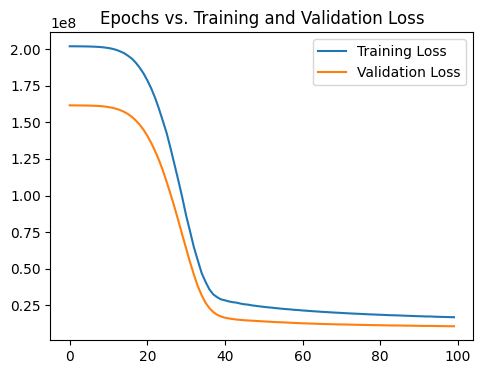

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

Due to early stopping, we were stopped long before any overfitting could occur. This would have been signalled once the validation loss starts increasing while the training loss is still decreasing. 

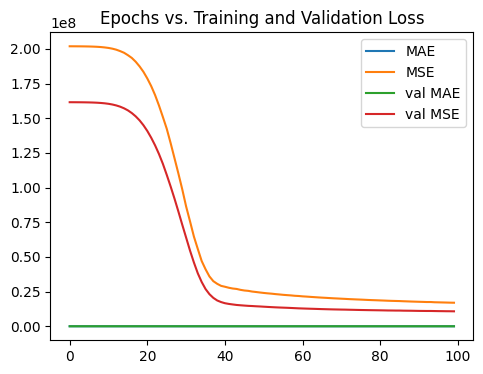

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['mse'], label='MSE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.plot(history.history['val_mse'], label='val MSE')

plt.legend()
plt.title('Epochs vs. Training and Validation Loss')


plt.show()


In [44]:
complex_nn_model.evaluate(X_test, y_test)



2/2 [==============================] - 0s 5ms/step - loss: 10790922.0000 - mae: 2474.9199 - mse: 10790922.0000


[10790922.0, 2474.919921875, 10790922.0]

## Comparing across all models

In [45]:
## Other results
ols_pred = ols_model.predict(sm.add_constant(X_test))
print('OLS MAE = ', round(sm.tools.eval_measures.meanabs(ols_pred,y_test),2))
print('OLS MSE = ', round(sm.tools.eval_measures.mse(ols_pred,y_test),2)/1e6, 'x 10^6')
print("==============================================================================\n")

## Neural network
print('NN MAE = ', round(nn_model_linear.evaluate(X_test, y_test)[1],2))
print('NN MSE = ', round(nn_model_linear.evaluate(X_test, y_test)[2],2)/1e6, 'x 10^6')
print("==============================================================================\n")


## New complex model 
print('NN MAE = ', round(complex_nn_model.evaluate(X_test, y_test)[1],2))
print('NN MSE = ', round(complex_nn_model.evaluate(X_test, y_test)[2],2)/1e6, 'x 10^6')

OLS MAE =  2487.99
OLS MSE =  9.40458709 x 10^6

2/2 [==============================] - 0s 5ms/step - loss: 161509024.0000 - mae: 8853.9102 - mse: 161509024.0000
NN MAE =  8853.91
2/2 [==============================] - 0s 5ms/step - loss: 161509024.0000 - mae: 8853.9102 - mse: 161509024.0000
NN MSE =  161.509024 x 10^6

2/2 [==============================] - 0s 6ms/step - loss: 10790922.0000 - mae: 2474.9199 - mse: 10790922.0000
NN MAE =  2474.92
2/2 [==============================] - 0s 6ms/step - loss: 10790922.0000 - mae: 2474.9199 - mse: 10790922.0000
NN MSE =  10.790922 x 10^6


Let us form them into a table for an easier visual comparison

In [46]:
## save metrics
ols_mae = round(sm.tools.eval_measures.meanabs(ols_pred, y_test), 2)
ols_mse = round(sm.tools.eval_measures.mse(ols_pred, y_test), 2)
nn_mae = round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[1], 2)
nn_mse = round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[2], 2)
complex_nn_mae = round(complex_nn_model.evaluate(X_test, y_test, verbose=0)[1], 2)
complex_nn_mse = round(complex_nn_model.evaluate(X_test, y_test, verbose=0)[2], 2)

## make df 
model_results_df = pd.DataFrame({
    'Model': ['OLS', 'Linear Neural Network', 'Complex Neural Network'],
    'MAE': [ols_mae, nn_mae, complex_nn_mae],
    'MSE x 10^6': [ols_mse / 1e6, nn_mse / 1e6, complex_nn_mse / 1e6]
})

print(model_results_df.sort_values('MSE x 10^6'))


                    Model      MAE  MSE x 10^6
0                     OLS  2487.99    9.404587
2  Complex Neural Network  2474.92   10.790922
1   Linear Neural Network  8853.91  161.509024


### Visualise the differences

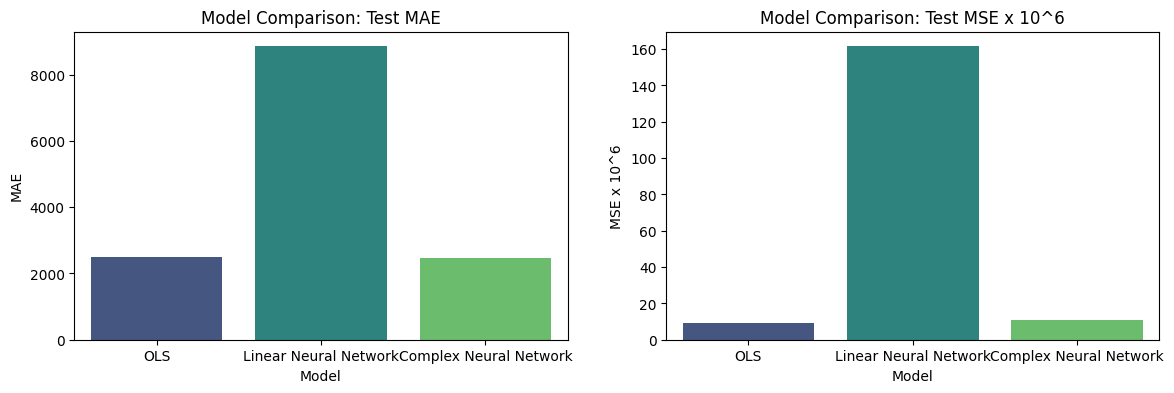

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
f, axes = plt.subplots(1,2,figsize=(14, 4))

# Plot MAE
sns.barplot(x='Model', y='MAE', data=model_results_df, palette='viridis', ax=axes[0])
axes[0].set_title('Model Comparison: Test MAE')

# Plot MSE
sns.barplot(x='Model', y='MSE x 10^6', data=model_results_df, palette='viridis', ax=axes[1])
axes[1].set_title('Model Comparison: Test MSE x 10^6')
plt.show()


We can see that the complex neural network has results much similar to the OLS now. 

# Hyperparameter tuning / Changing the fitting process for linear neural network

It is obvious that the linear neural network was greatly underfitted (small coefficients and large errors). Let us see what we can do to change the training process

Let us try to change the learning rate (increase) and increase the number of epochs, to see if there is any effect

In [48]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.01) ## learning rate
nn_model_linear.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history = nn_model_linear.fit(X_train, y_train, epochs = 500, verbose = 0) ##increase epochs


In [49]:
## CHeck results
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[1], 2))
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[2], 2)/1e6)

8825.29
158.9088


Only slight improvements -- lets try increasing the learning rate again

In [50]:
## INCREASE LR TO 0.1
optimizer = Adam(learning_rate=0.1) ## learning rate
nn_model_linear.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history = nn_model_linear.fit(X_train, y_train, epochs = 500, verbose = 0) ##increase epochs

## CHeck results
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[1], 2))
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[2], 2)/1e6)

8522.03
136.0352


In [51]:
## INCREASE LR TO 10
optimizer = Adam(learning_rate=10) ## learning rate
nn_model_linear.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history = nn_model_linear.fit(X_train, y_train, epochs = 500, verbose = 0) ##increase epochs

## CHeck results
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[1], 2))
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[2], 2)/1e6)

2555.73
10.037398


In [52]:
## INCREASE LR TO 100
optimizer = Adam(learning_rate=100) ## learning rate
nn_model_linear.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history = nn_model_linear.fit(X_train, y_train, epochs = 500, verbose = 0) ##increase epochs

## CHeck results
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[1], 2))
print(round(nn_model_linear.evaluate(X_test, y_test, verbose=0)[2], 2)/1e6)

2518.63
9.742567


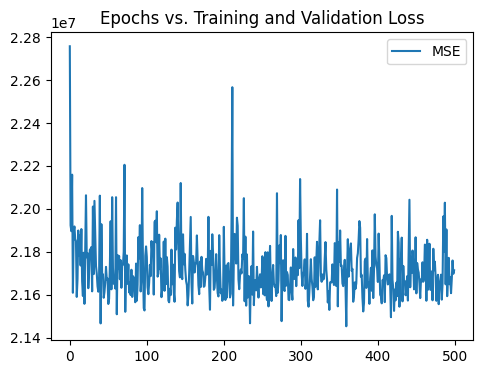

In [53]:
plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
#plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['mse'], label='MSE')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')
plt.show()


This is the lowest MAE and MSE we have been able to get via linear neural network with no hidden layers and no activation function. 

## Changing the fitting process for complex neural network 

### Trying different activation functions?

* Relu
* Leaky relu
* Sigmoid 
* Tanh

### Try: Leaky Relu (from Relu)

In [54]:
complex_nn_model_leakyrelu = Sequential([
    Dense(128, activation='leaky_relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='leaky_relu'),
    Dense(32, activation='leaky_relu'),
    Dense(1)  ## single neuron without an activation for regression tasks.
])

In [55]:
## Compile again
complex_nn_model_leakyrelu.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

## Training the model -- but now with mre options
## We use methods called callbacks to save some information during training, such as 
## End of some epochs
from tensorflow.keras.callbacks import EarlyStopping

## Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, ## stops the model fitting process if there is no improvement in validation for 10 epochs
                           restore_best_weights=True) ## take the estimated parameters that gave the best results
history = complex_nn_model_leakyrelu.fit(X_train, y_train, epochs=100, 
                               validation_data=(X_test, y_test), 
                               callbacks=[early_stop],
                              verbose = 0) ## Add the callback into the fitting function


## Patience -- we should be **patient** enough such that if the model improves only at 
## a later epoch, we do not miss out on that opportunity.
# Hence it should not be too small! 

In [56]:
complex_nn_leaky_loss,complex_nn_leaky_mae, complex_nn_leaky_mse=  complex_nn_model_leakyrelu.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 12437767.0000 - mae: 2807.6069 - mse: 12437767.0000


In [57]:
## Add the new result -- via the loc method, at the last index of the dataframe, which takes in a list 
#via the append method, which takes in a new dictionary according to the columns 
model_results_df.loc[len(model_results_df)] = ['Complex NN Leaky Relu', complex_nn_leaky_mae, complex_nn_leaky_mse/1e6]

In [58]:
## Check the new results
#model_results_df.drop([3])

### Try others via a for loop

Instead of repeating lines of code, let us instead form a for loop and collect each history along the way

*Code was inspired from DataCamp course on neural networks*

In [59]:
activations = ['relu', 'leaky_relu', 'sigmoid', 'tanh']

## Activation results collector (dictionary)
activations_results_dict = {} ## init an empty dict that we will use to collect the callbacks during fit

## for loop to use each activation function, collect results and store inside the dictionary
for act_fn in activations:
    
    ## Step 1: define the model
    model = Sequential([ ## Immediately add all layers in one single line of code, via a list of each layer 
    Dense(128, activation=act_fn, input_shape=(X_train.shape[1],)),
    Dense(64, activation=act_fn),
    Dense(32, activation=act_fn),
    Dense(1)  ## single neuron without an activation for regression tasks.
])
    
    ## Step 2: compile
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    ## Step 3: Set early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, ## stops the model fitting process if there is no improvement in validation for 10 epochs
                           restore_best_weights=True) ## take the estimated parameters that gave the best results

    ## Step 4: get history
    history = model.fit(X_train, y_train, epochs=100, 
                               validation_data=(X_test, y_test), 
                               callbacks=[early_stop],
                              verbose = 0) ## Add the callback into the fitting function
    ## Step 5: save into dictionary
    activations_results_dict[act_fn] = history
    

In [60]:
## Check results 
print(activations_results_dict)
print(activations_results_dict.keys())

{'relu': <keras.callbacks.History object at 0x7d00c1e0fb20>, 'leaky_relu': <keras.callbacks.History object at 0x7d013c8ff7f0>, 'sigmoid': <keras.callbacks.History object at 0x7d016c9ef130>, 'tanh': <keras.callbacks.History object at 0x7d00c1a5b2e0>}
dict_keys(['relu', 'leaky_relu', 'sigmoid', 'tanh'])


## Visualise the results 

In [61]:
activations_results_dict['relu'].history.keys()
## We can visualise validation loss (validation error)

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [62]:
validation_losses = [activations_results_dict[act_fn].history['val_loss'] for act_fn in activations]
training_losses = [activations_results_dict[act_fn].history['loss'] for act_fn in activations]

## In order to turn the losses into something easier to interpret like a dataframe
# we first have to match each list within the list to the activation function name,
# then turn it into a dict, then insert into the dataframe method

## Zip to match the entries of each list item with each other 
temp_dict_validation = dict(zip(activations, validation_losses))
temp_dict_train = dict(zip(activations, training_losses))

## Turn into a pd.DataFrame
act_fn_valid_loss_df = pd.DataFrame(temp_dict_validation)
act_fn_train_loss_df = pd.DataFrame(temp_dict_train)

In [63]:
print(act_fn_valid_loss_df.head())
print(act_fn_train_loss_df.head())

          relu   leaky_relu      sigmoid         tanh
0  161546688.0  161542608.0  161545200.0  161534176.0
1  161534976.0  161529104.0  161534240.0  161512064.0
2  161518496.0  161509136.0  161524144.0  161489424.0
3  161493856.0  161478832.0  161515456.0  161468592.0
4  161456032.0  161431360.0  161508256.0  161451808.0
          relu   leaky_relu      sigmoid         tanh
0  201874928.0  201869392.0  201873488.0  201869600.0
1  201862304.0  201855648.0  201860880.0  201840656.0
2  201846624.0  201836080.0  201849136.0  201813200.0
3  201823296.0  201808320.0  201838816.0  201785168.0
4  201790432.0  201765520.0  201829264.0  201761808.0


Text(0.5, 1.0, 'Validation losses against epochs, per activation functions')

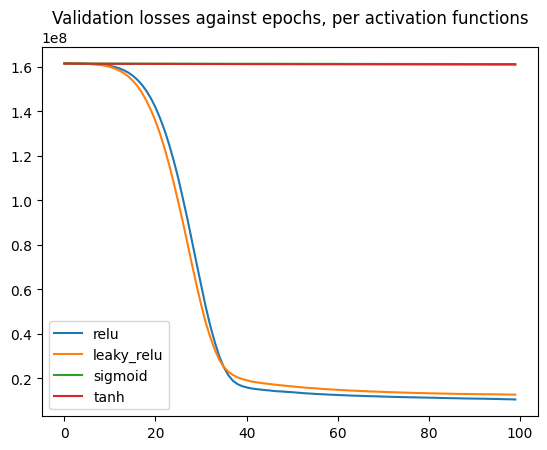

In [64]:
act_fn_valid_loss_df.plot()
plt.title('Validation losses against epochs, per activation functions')

Text(0.5, 1.0, 'Training losses against epochs, per activation functions')

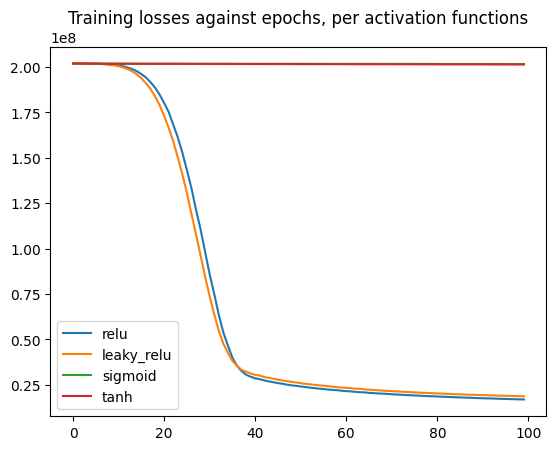

In [65]:
act_fn_train_loss_df.plot()
plt.title('Training losses against epochs, per activation functions')

### Activation function results

Sigmoid and tanh were the worst performers, while relu and leaky_relu excelled for this dataset. An interesting insight that leaky_relu allowed for a much faster initial convergence, but relu was able to catch up later on. 